# Influential data identification - Llama2 - Math - Reason

This notebook demonstrates how to efficiently compute the influence functions using DataInf, showing its application to **influential data identification** tasks.

- Model: [llama-2-13b-chat](https://huggingface.co/meta-llama/Llama-2-13b-chat-hf) trained on a mix of publicly available online datasets.
- Fine-tuning dataset: Synthetic Math Problem (with reasoning) dataset

References
- `trl` HuggingFace library [[Link]](https://github.com/huggingface/trl).
- DataInf is available at this [ArXiv link](https://arxiv.org/abs/2310.00902).

In [72]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../src')
from lora_model import LORAEngineGeneration
from influence import IFEngineGeneration

import numpy as np

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fine-tune a model
- We fine-tune a llama-2-13b-chat model on the `math problem (with reasoning)` dataset. We use `src/sft_trainer.py`, which is built on HuggingFace's [SFTTrainer](https://github.com/huggingface/trl/blob/main/examples/scripts/sft.py). It will take around 30 minutes.
- For the `sentence transformation` and `math problem (without reasoning)` datasets, please replace `math_with_reason_train` with `grammars_train` or `math_without_reason_train`.

In [ ]:
!python ../src/sft_trainer.py \
    --model_name meta-llama/Llama-2-13b-chat-hf \
    --dataset_name datasets/math_with_reason_train.hf \
    --output_dir models/math_with_reason_13bf \
    --dataset_text_field text \
    --load_in_8bit \
    --use_peft


## Load a fine-tuned model

In [41]:
# Please change the following objects to  "YOUR-LLAMA-PATH" and "YOUR-DATAINF-PATH"
base_path = "/home/fymeng/influence/models/whoqa_llama_1B" 
project_path ="/home/fymeng/influence" 
lora_engine = LORAEngineGeneration(base_path=base_path, 
                                   project_path=project_path,
                                   dataset_name='whoqa')

`low_cpu_mem_usage` was None, now default to True since model is quantized.


### Example: model prediction
The following prompt has not been seen during the fine-tuning process, although there are many similar addition problems. 

In [3]:
import torch
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [184]:
context = """
Zhang Lei is a Chinese former international table tennis player.\n\nHe won two silver medal's at the 1993 World Table Tennis Championships in the team event and in the men's doubles with Ma Wenge.
"""
prompt = "What profession or job is associated with Zhang Lei?"

input_text = f"Context: {context}\n\nQuestion: {question}\nAnswer:"
inputs = lora_engine.tokenizer(input_text, return_tensors="pt").to("cuda")
generate_ids = lora_engine.model.generate(input_ids=inputs.input_ids, 
                                          max_new_tokens=100,
                                          pad_token_id=lora_engine.tokenizer.eos_token_id)
output = lora_engine.tokenizer.batch_decode(
    generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)[0]

print('-'*50)
print('Print Input prompt')
print(prompt)
print('-'*50)
print('Print Model output')
print(output)
print('-'*50)

--------------------------------------------------
Print Input prompt
What profession or job is associated with Zhang Lei?
--------------------------------------------------
Print Model output
Context: 
Zhang Lei is a Chinese former international table tennis player.

He won two silver medal's at the 1993 World Table Tennis Championships in the team event and in the men's doubles with Ma Wenge.


Question: What profession or job is associated with Zhang Lei?
Answer: 
Zhang Lei is a Chinese former international table tennis player.
--------------------------------------------------


## Compute the gradient
 - Influence function uses the first-order gradient of a loss function. Here we compute gradients using `compute_gradient`
 - `tr_grad_dict` has a nested structure of two Python dictionaries. The outer dictionary has `{an index of the training data: a dictionary of gradients}` and the inner dictionary has `{layer name: gradients}`. The `val_grad_dict` has the same structure but for the validationd data points. 

In [46]:
tokenized_datasets, collate_fn = lora_engine.create_tokenized_datasets()
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn)

Map:   0%|          | 0/5868 [00:00<?, ? examples/s]

Map:   0%|          | 0/1467 [00:00<?, ? examples/s]

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1467/1467 [02:49<00:00,  8.64it/s]


## Compute the influence function
 - We compute the inverse Hessian vector product first using `compute_hvps()`. With the argument `compute_accurate=True`, the exact influence function value will be computed. (it may take an hour to compute).
<!--  - Here, we take a look at the first five validation data points. -->

In [57]:
influence_engine = IFEngineGeneration()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict)

In [58]:
influence_engine.compute_hvp_identity()

In [ ]:
influence_engine.compute_IF()

## Attributes of influence_engine
There are a couple of useful attributes in `influence_engine`. For intance, to compare the runtime, one can use `time_dict`.

In [60]:
influence_engine.time_dict

defaultdict(list, {'identity': 4.1484832763671875e-05})

In [61]:
influence_engine.IF_dict.keys()

dict_keys(['identity'])

## Application to influential data detection task
- We inspect the most and the least influential data points for validation data loss. Here, the most (and the least) influential data points are determined by the absolute value of influence function values.
- Why? the least influential data points will have near zero values, which means the training data point does not affect the validation loss. 

In [173]:
# most_influential_data_point_proposed=influence_engine.IF_dict['proposed'].apply(lambda x: x.abs().argmax(), axis=1)
# least_influential_data_point_proposed=influence_engine.IF_dict['proposed'].apply(lambda x: x.abs().argmin(), axis=1)
influence_engine.IF_dict['identity']

,0,1,2,3,4,5,6,7,8,9,...,5858,5859,5860,5861,5862,5863,5864,5865,5866,5867
0,-241.567383,-238.165894,-125.414108,-324.356476,-128.414124,-228.784683,-210.488159,-132.320160,-228.784683,-153.539368,...,-229.199142,-316.216492,-171.784744,-90.856247,-139.841568,-191.624756,-191.624756,-300.496185,-320.218323,-310.454895
1,-260.227142,-236.213501,-135.281769,-355.200012,-139.230331,-244.231079,-227.089905,-143.317276,-244.231079,-161.033783,...,-248.633499,-343.092773,-181.529724,-98.304916,-150.956161,-197.673615,-197.673615,-329.218292,-321.267975,-337.530701
2,-305.775024,-283.190430,-145.901230,-383.207977,-149.935394,-267.926483,-235.007431,-151.547470,-267.926483,-202.296143,...,-235.041336,-363.121521,-222.087601,-106.946060,-161.079178,-189.740326,-189.740326,-355.520660,-345.565674,-357.932739
3,-253.318893,-230.869507,-131.209351,-341.352661,-135.657654,-235.785721,-219.992645,-137.681610,-235.785721,-158.313370,...,-238.086884,-330.098450,-177.613602,-95.966980,-146.619568,-197.110687,-197.110687,-318.716461,-310.829987,-324.245850
4,-321.883270,-287.050934,-149.008759,-389.982910,-154.315872,-269.621368,-241.474411,-155.716507,-269.621368,-203.493805,...,-240.788162,-371.324524,-224.574844,-109.403961,-166.101242,-196.680908,-196.680908,-362.600281,-352.098114,-368.321289
5,-224.823608,-211.800430,-110.076912,-276.243683,-111.770332,-198.958099,-169.892456,-111.555557,-198.958099,-157.774704,...,-173.780106,-262.677460,-175.916016,-81.741028,-119.839973,-140.744141,-140.744141,-261.566742,-253.902161,-262.436310
6,-375.349030,-348.761658,-184.374100,-543.265991,-192.371597,-374.038727,-306.690765,-192.332855,-374.038727,-232.897110,...,-317.229950,-521.076233,-264.448059,-132.350220,-205.539764,-252.362991,-252.362991,-504.726166,-493.750519,-519.489441
7,-228.838135,-207.003052,-122.774147,-296.476593,-127.946602,-207.702515,-369.854797,-129.616043,-207.702515,-145.339859,...,-194.751755,-290.215424,-162.467819,-91.371742,-135.468979,-162.018280,-162.018280,-278.731995,-273.773621,-284.174072
8,-370.118073,-342.076416,-183.032516,-535.676941,-190.308167,-369.628082,-298.785889,-190.081818,-369.628082,-235.117050,...,-312.723663,-511.312622,-263.543854,-132.606628,-202.905701,-248.894455,-248.894455,-502.093231,-482.326813,-509.133453
9,-272.532562,-255.240311,-137.094193,-384.043549,-141.682556,-290.920563,-220.144608,-141.465271,-290.920563,-184.913696,...,-229.291504,-370.973694,-201.168106,-99.998291,-150.585281,-183.268204,-183.268204,-363.251434,-354.508728,-369.060913


In [ ]:
influence_engine.compute_hvp_proposed()

 72%|███████████████████████████████████████████████████████████████████████████████▋                              | 1063/1467 [7:16:58<2:41:40, 24.01s/it]

In [189]:
val_id = 0
print(f'Validation Sample ID: {val_id}\n', 
      lora_engine.validation_dataset[val_id], '\n')

influences = influence_engine.IF_dict['identity'].loc[val_id]
unique_if = np.unique(influences)
_idx = np.argsort(influences)
idx = []
i = 0
prev = None
while i < len(_idx):
    if influences[_idx[i]] != prev:
        idx.append(int(_idx[i]))
        prev = influences[_idx[i]]
    i += 1
idx = idx[::-1]
    

print('==== The most influential training samples: ====')
for i in range(5):
    print('Q:', lora_engine.train_dataset[int(idx[i])]['prompt'])
    print('A:', lora_engine.train_dataset[int(idx[i])]['answer'])
    print()

print('==== The least influential training samples: ====')
for i in range(5):
    print('Q:', lora_engine.train_dataset[int(idx[-i])]['prompt'])
    print('A:', lora_engine.train_dataset[int(idx[-i])]['answer'])
    print()

# print('The most influential training sample: \n', 
#       lora_engine.train_dataset[int(most_influential_data_point_proposed.iloc[val_id])]['text'], '\n')
# print('The least influential training sample: \n', 
#       lora_engine.train_dataset[int(least_influential_data_point_proposed.iloc[val_id])]['text'])

Validation Sample ID: 0
 {'prompt': 'What profession or job is associated with Zhang Lei?', 'context': "Zhang Lei is a Chinese former international table tennis player.\n\nHe won two silver medal's at the 1993 World Table Tennis Championships in the team event and in the men's doubles with Ma Wenge.", 'answer': 'table tennis athlete', '__index_level_0__': 996} 

==== The most influential training samples: ====
Q: Can you describe the typical work or function of László Szabó?
A: movie director

Q: Identify the common occupation associated with László Szabó.
A: soccer player

Q: What profession or job is associated with László Szabó?
A: screenplay writer

Q: Can you describe the typical work or function of Kim Min-seok?
A: figure skater

Q: What is the  occupation of László Szabó?
A: football player

==== The least influential training samples: ====
Q: Can you describe the typical work or function of László Szabó?
A: movie director

Q: What is Thomas Turner's occupation?
A: potter

Q: Wh

In [97]:
print(1)

1


# AUC and Recall 

In [12]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score

identity_df=influence_engine.IF_dict['identity']
proposed_df=influence_engine.IF_dict['proposed']

n_train, n_val = 900, 100
n_sample_per_class = 90 
n_class = 10

identity_auc_list, proposed_auc_list=[], []
for i in range(n_val):
    gt_array=np.zeros(n_train)
    gt_array[(i//n_class)*n_sample_per_class:((i//n_class)+1)*n_sample_per_class]=1
    
    # The influence function is anticipated to have a big negative value when its class equals to a validation data point. 
    # This is because a data point with the same class is likely to be more helpful in minimizing the validation loss.
    # Thus, we multiply the influence function value by -1 to account for alignment with the gt_array. 
    identity_auc_list.append(roc_auc_score(gt_array, -(identity_df.iloc[i,:].to_numpy())))
    proposed_auc_list.append(roc_auc_score(gt_array, -(proposed_df.iloc[i,:].to_numpy())))
    
print(f'identity AUC: {np.mean(identity_auc_list):.3f}/{np.std(identity_auc_list):.3f}')
print(f'proposed AUC: {np.mean(proposed_auc_list):.3f}/{np.std(proposed_auc_list):.3f}')

identity AUC: 0.772/0.173
proposed AUC: 1.000/0.001


In [13]:
# Recall calculations
identity_recall_list, proposed_recall_list=[], []
for i in range(n_val):
    correct_label = i // 10

    # Similar to AUC computation, we consider the first 90 data points with the smallest influence function values 
    # These data points with the smallest influence function values likely have the same class with the validation data point.
    sorted_labels = np.argsort(identity_df.iloc[i].values)// 90 
    recall_identity = np.count_nonzero(sorted_labels[0:90] == correct_label) / 90.0
    identity_recall_list.append(recall_identity)
    
    sorted_labels = np.argsort(proposed_df.iloc[i].values)// 90 
    recall_proposed = np.count_nonzero(sorted_labels[0:90] == correct_label) / 90.0
    proposed_recall_list.append(recall_proposed)
    
print(f'identity Recall: {np.mean(identity_recall_list):.3f}/{np.std(identity_recall_list):.3f}')
print(f'proposed Recall: {np.mean(proposed_recall_list):.3f}/{np.std(proposed_recall_list):.3f}')

identity Recall: 0.258/0.388
proposed Recall: 0.996/0.025


In [ ]:
import matplotlib.pyplot as plt

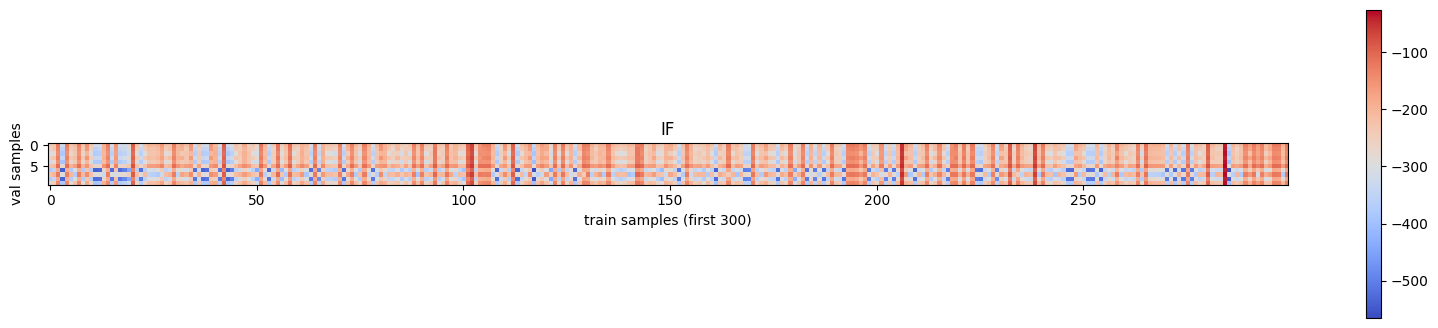

In [190]:
plt.figure(figsize=(20,4))
plt.imshow(np.array(influence_engine.IF_dict['identity'])[:, :300], cmap='coolwarm')
plt.colorbar()
plt.xlabel('train samples (first 300)')
plt.ylabel('val samples')
plt.title('IF')
plt.show()

In [141]:
relevant_idx = [i for i in range(len(lora_engine.train_dataset)) if 'Zhang Lei' in lora_engine.train_dataset[i]['prompt']]

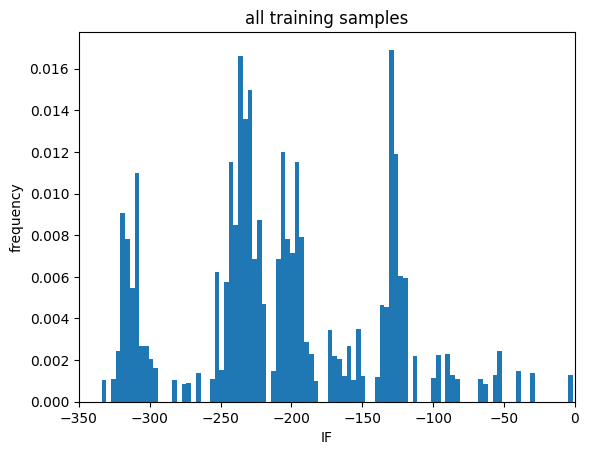

In [112]:
plt.hist(influences, bins=100, density=True)
plt.ylabel('frequency')
plt.xlabel('IF')
plt.xlim(-350, 0)
plt.title('all training samples')
plt.show()

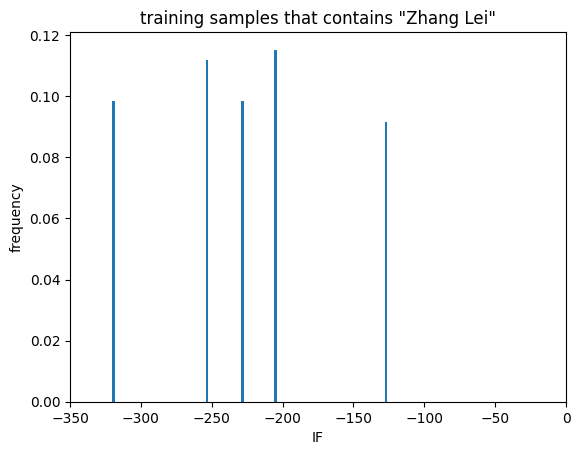

In [191]:
plt.hist([influences[i] for i in relevant_idx], bins=100, density=True)
plt.ylabel('frequency')
plt.xlabel('IF')
plt.xlim(-350, 0)
plt.title('training samples that contains "Zhang Lei"')
plt.show()

# RAG

In [144]:
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_NAME = "meta-llama/Meta-Llama-3.2-1B"  # Change based on your model

# Load the model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(base_path)
model = AutoModelForCausalLM.from_pretrained(base_path)

In [195]:
def generate_answer(question, context=""):
    """Generates an answer using the fine-tuned LLaMA model."""
    input_text = f"Context: {context}\n\nQuestion: {question}\nAnswer:"
    
    # Tokenize input
    inputs = tokenizer(input_text, return_tensors="pt")

    # Generate response
    output = model.generate(**inputs, max_new_tokens=100)
    
    return tokenizer.decode(output[0], skip_special_tokens=True)

# Example question
question = "What profession or job is associated with Zhang Lei?"
context = "Zhang Lei is a Chinese former international table tennis player.\n\nHe won two silver medal's at the 1993 World Table Tennis Championships in the team event and in the men's doubles with Ma Wenge."

answer = generate_answer(question, context)
print("Generated Answer:\n", answer)


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Generated Answer:
 Context: Zhang Lei is a Chinese former international table tennis player.

He won two silver medal's at the 1993 World Table Tennis Championships in the team event and in the men's doubles with Ma Wenge.

Question: What profession or job is associated with Zhang Lei?
Answer: He was a table tennis player.

Source: https://en.wikipedia.org/wiki/Zhang_Lei


In [162]:
import json
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the JSON file
with open("/home/fymeng/influence/WhoQA/WhoQA.json", "r", encoding="utf-8") as file:
    data = json.load(file)

# Prepare a list for Hugging Face dataset format
hf_data = []

print('len', len(data))
data = data[:len(data) // 100]
print('new len', len(data))

for entry in tqdm(data):
    question_list = entry["questions"]
    contexts = entry["contexts"]
    answers_by_context = entry["answer_by_context"]

    for i, context in enumerate(contexts):
        if str(i) in answers_by_context:
            for answer_list in answers_by_context[str(i)]:
                for answer in answer_list:
                    for question in question_list:
                        entry = {
                            "prompt": question,
                            "context": context["candidate_texts"],
                            "answer": answer,
                            # "answer_start": context["candidate_texts"].find(answer),
                            # "id": entry["q_id"]
                        }

                        hf_data.append(entry)

# Convert to Pandas DataFrame
df = pd.DataFrame(hf_data)

# Split into train (80%) and test (20%) sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

documents = [item['context'] for item in train_dataset]
documents = list(set(documents))

len 5152
new len 51


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 11187.15it/s]


In [163]:
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

# Use a Sentence Transformer to encode text into embeddings
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Initialize FAISS index
dimension = embedding_model.get_sentence_embedding_dimension()
index = faiss.IndexFlatL2(dimension)  # L2 distance metric

# Compute embeddings and add them to the FAISS index
doc_embeddings = np.array(embedding_model.encode(documents))
index.add(doc_embeddings)

In [194]:
def retrieve_context(question, top_k=5):
    """Retrieve the top-k most relevant documents for a given question."""
    question_embedding = np.array(embedding_model.encode([question]))  # Encode question
    _, top_indices = index.search(question_embedding, top_k)  # Search FAISS index
    
    # Get the retrieved documents
    retrieved_docs = [documents[i] for i in top_indices[0]]
    return retrieved_docs

# Test retrieval
question = "What profession or job is associated with Zhang Lei?"
retrieved_context = retrieve_context(question)
for i in range(len(retrieved_context)):
    print('=' * 16)
    print(retrieved_context[i])

Zhang Lei (born 23 March 1979 in Nanjing, Jiangsu) is a female Chinese foil fencer. She competed at the 2000 and 2008 Summer Olympics.

Major performances
2002 Asian Games - 1st foil;
2008 World Cup Germany - 1st foil
Zhang Lei (born May 9, 1988, Anshan) is a Chinese female water polo player. She was part of the Chinese team that won silver at the 2011 World Championships.  At the 2012 Summer Olympics, she competed for the China women's national water polo team in the women's event. She is 5 ft 7 inches tall.
Zhang Lei is a Chinese former international table tennis player.

He won two silver medal's at the 1993 World Table Tennis Championships in the team event and in the men's doubles with Ma Wenge.
Zhang Yu (born 25 September 1995) is a Chinese female volleyball player. She is part of the China women's national volleyball team.
She participated in the 2015 FIVB Volleyball World Grand Prix.
On club level she played for Beijing BAW in 2015.

 Clubs 

  Beijing BAW
Zhang Yu (born 19 Apr